In [25]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
#sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [349]:
refseq = pd.read_csv("../data/assembly_summary_refseq.txt", sep = "\t")

/tmp/ipykernel_30982/1251523544.py:1: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  refseq = pd.read_csv("../data/assembly_summary_refseq.txt", sep = "\t")


In [357]:
refseq = refseq.sort_values("species_taxid").drop_duplicates("species_taxid").reset_index(drop=True)

In [358]:
refseq["genome_size"].sum()/1000000000

2339.490698212

In [351]:
refseq.columns

Index(['#assembly_accession', 'bioproject', 'biosample', 'wgs_master',
       'refseq_category', 'taxid', 'species_taxid', 'organism_name',
       'infraspecific_name', 'isolate', 'version_status', 'assembly_level',
       'release_type', 'genome_rep', 'seq_rel_date', 'asm_name',
       'asm_submitter', 'gbrs_paired_asm', 'paired_asm_comp', 'ftp_path',
       'excluded_from_refseq', 'relation_to_type_material',
       'asm_not_live_date', 'assembly_type', 'group', 'genome_size',
       'genome_size_ungapped', 'gc_percent', 'replicon_count',
       'scaffold_count', 'contig_count', 'annotation_provider',
       'annotation_name', 'annotation_date', 'total_gene_count',
       'protein_coding_gene_count', 'non_coding_gene_count', 'pubmed_id'],
      dtype='object')

Mapping with minimap2:

In [374]:
%%bash
source ~/.bashrc
for MIX in MixA MixB MixC MixD; do
    for REF in $( ls ../examples/*.fna.gz | cut -d"/" -f3 | rev | cut -d"." -f3- | rev ); do
        minimap2 -ax sr -t 4 -N 500 --sam-hit-only ../examples/${REF}.fna.gz \
            ../examples/${MIX}_1.fq.gz ../examples/${MIX}_2.fq.gz \
            | awk '$3!="*"' | samtools view -bS - > ../examples/${MIX}_${REF}_minimap2.bam
    done
    samtools merge -@ 4 -n ../examples/${MIX}_minimap2.bam ../examples/${MIX}_*_minimap2.bam
    samtools sort -@ 4 -m 2G -n -O bam -o ../examples/${MIX}_minimap2.sorted.bam ../examples/${MIX}_minimap2.bam
    rm ../examples/${MIX}_minimap2.bam
    rm ../examples/${MIX}_GCF*_minimap2.bam
done

[M::mm_idx_gen::0.182*1.00] collected minimizers
[M::mm_idx_gen::0.223*1.28] sorted minimizers
[M::main::0.223*1.28] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.223*1.28] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.230*1.27] distinct minimizers: 757233 (99.27% are singletons); average occurrences: 1.021; average spacing: 6.004; total length: 4641652
[M::worker_pipeline::0.543*1.27] mapped 27324 sequences
[M::main] Version: 2.30-r1287
[M::main] CMD: minimap2 -ax sr -t 4 -N 500 --sam-hit-only ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz ../examples/MixA_1.fq.gz ../examples/MixA_2.fq.gz
[M::main] Real time: 0.552 sec; CPU: 0.700 sec; Peak RSS: 0.058 GB
[M::mm_idx_gen::0.144*0.98] collected minimizers
[M::mm_idx_gen::0.189*1.41] sorted minimizers
[M::main::0.189*1.41] loaded/built the index for 3 target sequence(s)
[M::mm_mapopt_update::0.189*1.41] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; 

Building BWA and Bowtie2 indexes:

In [343]:
%%bash
source ~/.bashrc
for REF in $( ls ../examples/*.fna.gz | cut -d"/" -f3 | rev | cut -d"." -f3- | rev ); do
    bowtie2-build --threads 4 ../examples/${REF}.fna.gz ../examples/${REF}.fna.gz
    bwa index ../examples/${REF}.fna.gz
done

Settings:
  Output files: "../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 16
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz


Building a SMALL index


Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 290103
Using parameters --bmax 217578 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 217578 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 44 sample suffixes
Generating random suffixes
QSorting 44 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSort

Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.3.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.3.bt2
Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.4.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.4.bt2
Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.1.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.1.bt2
Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.2.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.2.bt2
Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.rev.1.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.rev.1.bt2
Renaming ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.rev.2.bt2.tmp to ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz.rev.2.bt2
[bwa_index] Pack FASTA... 0.06 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.20 seconds elapse.
[bwa_index] Update BWT... 0.02 sec
[bwa_index] Pack forward-only FASTA.

Settings:
  Output files: "../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 16
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz


Building a SMALL index


Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:01
bmax according to bmaxDivN setting: 349662
Using parameters --bmax 262247 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 262247 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 44 sample suffixes
Generating random suffixes
QSorting 44 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSort

Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.3.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.3.bt2
Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.4.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.4.bt2
Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.1.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.1.bt2
Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.2.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.2.bt2
Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.rev.1.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.rev.1.bt2
Renaming ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.rev.2.bt2.tmp to ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz.rev.2.bt2
[bwa_index] Pack FASTA... 0.07 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.55 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA.

Settings:
  Output files: "../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 16
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz


Building a SMALL index


Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 290241
Using parameters --bmax 217681 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 217681 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 44 sample suffixes
Generating random suffixes
QSorting 44 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSort

Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.3.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.3.bt2
Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.4.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.4.bt2
Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.1.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.1.bt2
Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.2.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.2.bt2
Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.rev.1.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.rev.1.bt2
Renaming ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.rev.2.bt2.tmp to ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz.rev.2.bt2
[bwa_index] Pack FASTA... 0.06 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.34 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward

Settings:
  Output files: "../examples/GCF_000699345.1_11227-1_genomic.fna.gz.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 16
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  ../examples/GCF_000699345.1_11227-1_genomic.fna.gz


Building a SMALL index


Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 348773
Using parameters --bmax 261580 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 261580 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  V-Sorting samples time: 00:00:00
  Allocating rank array
  Ranking v-sort output
  Ranking v-sort output time: 00:00:00
  Invoking Larsson-Sadakane on ranks
  Invoking Larsson-Sadakane on ranks time: 00:00:00
  Sanity-checking and returning
Building samples
Reserving space for 44 sample suffixes
Generating random suffixes
QSorting 44 sample offsets, eliminating duplicates
QSorting sample offsets, eliminating duplicates time: 00:00:00
Multikey QSort

Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.3.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.3.bt2
Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.4.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.4.bt2
Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.1.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.1.bt2
Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.2.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.2.bt2
Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.rev.1.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.rev.1.bt2
Renaming ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.rev.2.bt2.tmp to ../examples/GCF_000699345.1_11227-1_genomic.fna.gz.rev.2.bt2
[bwa_index] Pack FASTA... 0.07 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.37 seconds elapse.
[bwa_index] Update BWT... 0.08 sec
[bwa_index] Pack forward-only FASTA... 0.14 sec


Mapping with BWA, Bowtie2 in local mode, and Bowtie2 in global mode:

In [375]:
%%bash
source ~/.bashrc
for MIX in MixA MixB MixC MixD; do
    for REF in $( ls ../examples/*.fna.gz | cut -d"/" -f3 | rev | cut -d"." -f3- | rev ); do
        bwa mem -t 4 -h 500 ../examples/${REF}.fna.gz \
            ../examples/${MIX}_1.fq.gz ../examples/${MIX}_2.fq.gz \
            | awk '$3!="*"' | samtools view -bS - > ../examples/${MIX}_${REF}_bwa.bam
    done
    samtools merge -@ 4 -n ../examples/${MIX}_bwa.bam ../examples/${MIX}_*_bwa.bam
    samtools sort -@ 4 -m 2G -n -O bam -o ../examples/${MIX}_bwa.sorted.bam ../examples/${MIX}_bwa.bam
    rm ../examples/${MIX}_bwa.bam
    rm ../examples/${MIX}_GCF*_bwa.bam
done

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 27324 sequences (4000429 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (10, 8684, 0, 6)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (131, 248, 498)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1232)
[M::mem_pestat] mean and std.dev: (314.00, 281.52)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1599)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (292, 395, 496)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 904)
[M::mem_pestat] mean and std.dev: (397.33, 160.07)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1108)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] skip orientati

In [377]:
%%bash
source ~/.bashrc
for MIX in MixA MixB MixC MixD; do
    for REF in $( ls ../examples/*.fna.gz | cut -d"/" -f3 | rev | cut -d"." -f3- | rev ); do
        bowtie2 --threads 4 -k 500 --end-to-end -x ../examples/${REF}.fna.gz \
            -1 ../examples/${MIX}_1.fq.gz -2 ../examples/${MIX}_2.fq.gz --no-unal \
            | awk '$3!="*"' | samtools view -bS - > ../examples/${MIX}_${REF}_bowtie_global.bam
    done
    samtools merge -@ 4 -n ../examples/${MIX}_bowtie_global.bam ../examples/${MIX}_*_bowtie_global.bam
    samtools sort -@ 4 -m 2G -n -O bam -o ../examples/${MIX}_bowtie_global.sorted.bam ../examples/${MIX}_bowtie_global.bam
    rm ../examples/${MIX}_bowtie_global.bam
    rm ../examples/${MIX}_GCF*_bowtie_global.bam
done

13662 reads; of these:
  13662 (100.00%) were paired; of these:
    7456 (54.57%) aligned concordantly 0 times
    6062 (44.37%) aligned concordantly exactly 1 time
    144 (1.05%) aligned concordantly >1 times
    ----
    7456 pairs aligned concordantly 0 times; of these:
      2009 (26.94%) aligned discordantly 1 time
    ----
    5447 pairs aligned 0 times concordantly or discordantly; of these:
      10894 mates make up the pairs; of these:
        10399 (95.46%) aligned 0 times
        389 (3.57%) aligned exactly 1 time
        106 (0.97%) aligned >1 times
61.94% overall alignment rate
13662 reads; of these:
  13662 (100.00%) were paired; of these:
    6865 (50.25%) aligned concordantly 0 times
    6470 (47.36%) aligned concordantly exactly 1 time
    327 (2.39%) aligned concordantly >1 times
    ----
    6865 pairs aligned concordantly 0 times; of these:
      1887 (27.49%) aligned discordantly 1 time
    ----
    4978 pairs aligned 0 times concordantly or discordantly; of these

In [378]:
%%bash
source ~/.bashrc
for MIX in MixA MixB MixC MixD; do
    for REF in $( ls ../examples/*.fna.gz | cut -d"/" -f3 | rev | cut -d"." -f3- | rev ); do
        bowtie2 --threads 4 -k 500 --local -x ../examples/${REF}.fna.gz \
            -1 ../examples/${MIX}_1.fq.gz -2 ../examples/${MIX}_2.fq.gz --no-unal \
            | awk '$3!="*"' | samtools view -bS - > ../examples/${MIX}_${REF}_bowtie_local.bam
    done
    samtools merge -@ 4 -n ../examples/${MIX}_bowtie_local.bam ../examples/${MIX}_*_bowtie_local.bam
    samtools sort -@ 4 -m 2G -n -O bam -o ../examples/${MIX}_bowtie_local.sorted.bam ../examples/${MIX}_bowtie_local.bam
    rm ../examples/${MIX}_bowtie_local.bam
    rm ../examples/${MIX}_GCF*_bowtie_local.bam
done

13662 reads; of these:
  13662 (100.00%) were paired; of these:
    7013 (51.33%) aligned concordantly 0 times
    6405 (46.88%) aligned concordantly exactly 1 time
    244 (1.79%) aligned concordantly >1 times
    ----
    7013 pairs aligned concordantly 0 times; of these:
      2027 (28.90%) aligned discordantly 1 time
    ----
    4986 pairs aligned 0 times concordantly or discordantly; of these:
      9972 mates make up the pairs; of these:
        9546 (95.73%) aligned 0 times
        261 (2.62%) aligned exactly 1 time
        165 (1.65%) aligned >1 times
65.06% overall alignment rate
13662 reads; of these:
  13662 (100.00%) were paired; of these:
    6427 (47.04%) aligned concordantly 0 times
    6757 (49.46%) aligned concordantly exactly 1 time
    478 (3.50%) aligned concordantly >1 times
    ----
    6427 pairs aligned concordantly 0 times; of these:
      1944 (30.25%) aligned discordantly 1 time
    ----
    4483 pairs aligned 0 times concordantly or discordantly; of these:


In [128]:
%%bash
echo -e "accession\taccession.version\ttaxid\tgi" > ../examples/acc2taxid
paste <( zcat ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) \
    <( zcat ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" | sed 's/$/\t511145/g') \
    <( zcat ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) >> ../examples/acc2taxid
paste <( zcat ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) \
    <( zcat ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" | sed 's/$/\t386585/g') \
    <( zcat ../examples/GCF_000008865.2_ASM886v2_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) >> ../examples/acc2taxid
paste <( zcat ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) \
    <( zcat ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" | sed 's/$/\t585054/g') \
    <( zcat ../examples/GCF_000026225.1_ASM2622v1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) >> ../examples/acc2taxid
paste <( zcat ../examples/GCF_000699345.1_11227-1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) \
    <( zcat ../examples/GCF_000699345.1_11227-1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" | sed 's/$/\t1455604/g') \
    <( zcat ../examples/GCF_000699345.1_11227-1_genomic.fna.gz | grep "^>" | cut -d" " -f1 | sed "s/>//g" ) >> ../examples/acc2taxid
gzip ../examples/acc2taxid

In [6]:
%%bash
cd ../examples
wget -q https://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump/new_taxdump.tar.gz 
tar -xzvf ./new_taxdump.tar.gz
gzip ./names.dmp
gzip ./nodes.dmp
rm ./*.dmp
rm ./new_taxdump.tar.gz 

citations.dmp
delnodes.dmp
division.dmp
excludedfromtype.dmp
fullnamelineage.dmp
gencode.dmp
host.dmp
images.dmp
merged.dmp
names.dmp
nodes.dmp
rankedlineage.dmp
taxidlineage.dmp
typematerial.dmp
typeoftype.dmp


In [108]:
%%bash
source ~/.bashrc
source activate base
conda activate cladeaid
for SAMP in ../examples/MixA_bowtie_global; do
    python ../cladeaid/cladeaid.py \
        --bam ${SAMP}.sorted.bam \
        --output ${SAMP} \
        --nodes ../examples/nodes.dmp.gz \
        --names ../examples/names.dmp.gz \
        --acc2taxid ../examples/acc2taxid.gz \
        --estimate_abundance --mash_reallocation \
        --reference_genome_list ../examples/references.list \
        --normalize \
        --threads 4
done    

[E::idx_find_and_load] Could not retrieve index file for '../examples/MixA_bowtie_global.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../examples/MixA_bowtie_global.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../examples/MixA_bowtie_global.sorted.bam'
../cladeaid/cladeaid.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propagated_counts[prop + "_Proportion"][i] = propagated_counts[prop + "_Bases"][i] / reference_sizes[propagated_counts["TaxID"][i]]


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 96 reference names in BAM
✅ Mapped 96 reference IDs to taxids
📖 Opening BAM file: ../examples/MixA_bowtie_global.sorted.bam
✅ Done: 12,766 read pairs assigned in           18.6s
🔢 Read groups with R1 + R2:             12,472
🔢 Read groups missing one end:           294
🧬 Paired reads with same taxid:                 9,136
🧬 Paired reads where one read is more specific:                 2,749
🧬 Paired reads with discordant taxid:           587
Mash distance matrix already exists. Skipping computation.
                                                    ../examples/GCF_000005845.2_ASM584v2_genomic.fna.gz  ...  ../examples/GCF_000699345.1_11227-1_genomic.fna.gz
../examples/GCF_000005845.2_ASM584v2_genomic.fn...                                           0.000000    ...                                           0.203604 
../examples/GCF_000008865.2_ASM886v2_genomic.fn...                                           0.02278

In [136]:
%%bash
source ~/.bashrc
source activate base
conda activate cladeaid
for SAMP in ../data/MixA_targetref_only ../data/MixB_targetref_only ../data/MixC_targetref_only ../data/MixD_targetref_only \
    ../data/MixA ../data/MixB ../data/MixC ../data/MixD ../data/MixE ../data/MixF ../data/MixG ../data/MixH ; do 
    python ../cladeaid/cladeaid.py \
        --bam ${SAMP}.merged.sorted.bam \
        --output ${SAMP}_euk \
        --nodes ../examples/nodes.dmp.gz \
        --names ../examples/names.dmp.gz \
        --acc2taxid ../data/acc2tid.gz \
        --estimate_abundance \
        --threads 4 --pairwise_dists ${SAMP}_euk.dists \
        --reference_genome_list ../data/references.list \
        --mash_reallocation
done

[E::idx_find_and_load] Could not retrieve index file for '../data/MixA_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixA_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixA_targetref_only.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 11,345 reference names in BAM
✅ Mapped 11345 reference IDs to taxids
📖 Opening BAM file: ../data/MixA_targetref_only.merged.sorted.bam
⏳ Processed 276,208 mappings → 42,188                   reads assigned
⏳ Processed 532,626 mappings → 80,939                   reads assigned
⏳ Processed 796,120 mappings → 120,978                   reads assigned
⏳ Processed 1,045,184 mappings → 162,969                   reads assigned
⏳ Processed 1,300,121 mappings → 206,535                   reads assigned
⏳ Processed 1,545,477 mappings → 246,925                   reads assigned
⏳ Processed 1,804,406 mappings → 291,797                   reads assigned
⏳ Processed 2,027,103 mappings → 351,974                   reads assigned
⏳ Processed 2,276,045 mappings → 419,503                   reads assigned
⏳ Processed 2,539,663 mappings → 462,914                   reads assigned
⏳ Processed 2,758,116 mappings → 496,583                   r

[E::idx_find_and_load] Could not retrieve index file for '../data/MixB_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixB_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixB_targetref_only.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 11,345 reference names in BAM
✅ Mapped 11345 reference IDs to taxids
📖 Opening BAM file: ../data/MixB_targetref_only.merged.sorted.bam
⏳ Processed 280,092 mappings → 42,783                   reads assigned
⏳ Processed 550,636 mappings → 83,740                   reads assigned
⏳ Processed 810,522 mappings → 129,910                   reads assigned
⏳ Processed 1,064,154 mappings → 185,614                   reads assigned
⏳ Processed 1,288,802 mappings → 253,116                   reads assigned
⏳ Processed 1,552,446 mappings → 305,399                   reads assigned
⏳ Processed 1,782,043 mappings → 340,908                   reads assigned
⏳ Processed 2,010,561 mappings → 376,101                   reads assigned
⏳ Processed 2,237,910 mappings → 411,198                   reads assigned
⏳ Processed 2,454,238 mappings → 444,906                   reads assigned
⏳ Processed 2,681,254 mappings → 480,177                   r

[E::idx_find_and_load] Could not retrieve index file for '../data/MixC_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixC_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixC_targetref_only.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 11,345 reference names in BAM
✅ Mapped 11345 reference IDs to taxids
📖 Opening BAM file: ../data/MixC_targetref_only.merged.sorted.bam
⏳ Processed 272,060 mappings → 41,555                   reads assigned
⏳ Processed 530,505 mappings → 80,610                   reads assigned
⏳ Processed 789,795 mappings → 120,042                   reads assigned
⏳ Processed 1,046,748 mappings → 163,242                   reads assigned
⏳ Processed 1,299,006 mappings → 206,396                   reads assigned
⏳ Processed 1,550,449 mappings → 253,130                   reads assigned
⏳ Processed 1,810,240 mappings → 293,611                   reads assigned
⏳ Processed 2,028,563 mappings → 326,867                   reads assigned
⏳ Processed 2,244,064 mappings → 357,360                   reads assigned
⏳ Processed 2,426,165 mappings → 384,942                   reads assigned
⏳ Processed 2,639,784 mappings → 416,788                   r

[E::idx_find_and_load] Could not retrieve index file for '../data/MixD_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixD_targetref_only.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixD_targetref_only.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 11,345 reference names in BAM
✅ Mapped 11345 reference IDs to taxids
📖 Opening BAM file: ../data/MixD_targetref_only.merged.sorted.bam
⏳ Processed 276,980 mappings → 42,385                   reads assigned
⏳ Processed 545,141 mappings → 91,765                   reads assigned
⏳ Processed 795,628 mappings → 131,271                   reads assigned
⏳ Processed 1,057,452 mappings → 171,486                   reads assigned
⏳ Processed 1,322,704 mappings → 214,290                   reads assigned
✅ Done: 239,876 read pairs assigned in           29.8s
🔢 Read groups with R1 + R2:             236,106
🔢 Read groups missing one end:           3,770
🧬 Paired reads with same taxid:                 181,163
🧬 Paired reads where one read is more specific:                 33,362
🧬 Paired reads with discordant taxid:           21,581
Mash distance matrix already exists. Skipping computation.


[E::idx_find_and_load] Could not retrieve index file for '../data/MixA.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixA.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixA.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixA.merged.sorted.bam
⏳ Processed 321,195 mappings → 24,810                   reads assigned
⏳ Processed 649,213 mappings → 46,191                   reads assigned
⏳ Processed 981,833 mappings → 65,876                   reads assigned
⏳ Processed 1,324,338 mappings → 86,333                   reads assigned
⏳ Processed 1,657,605 mappings → 106,522                   reads assigned
⏳ Processed 1,995,736 mappings → 126,811                   reads assigned
⏳ Processed 2,292,537 mappings → 152,715                   reads assigned
⏳ Processed 2,605,135 mappings → 185,437                   reads assigned
⏳ Processed 2,922,049 mappings → 207,476                   reads assigned
⏳ Processed 3,239,995 mappings → 229,421                   reads assigned
⏳ Processed 3,574,675 mappings → 253,090                   reads assigne

[E::idx_find_and_load] Could not retrieve index file for '../data/MixB.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixB.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixB.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixB.merged.sorted.bam
⏳ Processed 310,982 mappings → 23,964                   reads assigned
⏳ Processed 649,117 mappings → 46,218                   reads assigned
⏳ Processed 977,242 mappings → 65,710                   reads assigned
⏳ Processed 1,322,806 mappings → 88,314                   reads assigned
⏳ Processed 1,622,817 mappings → 120,105                   reads assigned
⏳ Processed 1,927,154 mappings → 147,101                   reads assigned
⏳ Processed 2,198,381 mappings → 172,346                   reads assigned
⏳ Processed 2,435,185 mappings → 201,559                   reads assigned
⏳ Processed 2,646,494 mappings → 230,422                   reads assigned
⏳ Processed 2,906,494 mappings → 258,960                   reads assigned
⏳ Processed 3,192,340 mappings → 285,344                   reads assigne

[E::idx_find_and_load] Could not retrieve index file for '../data/MixC.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixC.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixC.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixC.merged.sorted.bam
⏳ Processed 319,116 mappings → 24,629                   reads assigned
⏳ Processed 665,284 mappings → 47,119                   reads assigned
⏳ Processed 1,008,237 mappings → 67,426                   reads assigned
⏳ Processed 1,344,677 mappings → 87,567                   reads assigned
⏳ Processed 1,682,189 mappings → 108,038                   reads assigned
⏳ Processed 2,029,587 mappings → 128,957                   reads assigned
⏳ Processed 2,344,989 mappings → 158,290                   reads assigned
⏳ Processed 2,662,774 mappings → 189,448                   reads assigned
⏳ Processed 2,989,305 mappings → 212,218                   reads assigned
⏳ Processed 3,304,384 mappings → 234,890                   reads assigned
⏳ Processed 3,598,770 mappings → 262,301                   reads assig

[E::idx_find_and_load] Could not retrieve index file for '../data/MixD.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixD.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixD.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixD.merged.sorted.bam
⏳ Processed 310,349 mappings → 23,911                   reads assigned
⏳ Processed 623,484 mappings → 45,015                   reads assigned
⏳ Processed 953,816 mappings → 64,955                   reads assigned
⏳ Processed 1,229,616 mappings → 89,695                   reads assigned
⏳ Processed 1,514,512 mappings → 112,355                   reads assigned
⏳ Processed 1,817,710 mappings → 133,214                   reads assigned
⏳ Processed 2,149,833 mappings → 152,801                   reads assigned
⏳ Processed 2,490,824 mappings → 173,080                   reads assigned
⏳ Processed 2,826,373 mappings → 194,293                   reads assigned
⏳ Processed 3,126,001 mappings → 215,245                   reads assigned
⏳ Processed 3,407,797 mappings → 236,473                   reads assigne

[E::idx_find_and_load] Could not retrieve index file for '../data/MixE.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixE.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixE.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixE.merged.sorted.bam
⏳ Processed 294,502 mappings → 36,758                   reads assigned
⏳ Processed 601,937 mappings → 70,211                   reads assigned
⏳ Processed 922,410 mappings → 93,881                   reads assigned
⏳ Processed 1,230,919 mappings → 123,157                   reads assigned
⏳ Processed 1,506,408 mappings → 165,016                   reads assigned
⏳ Processed 1,800,966 mappings → 212,529                   reads assigned
⏳ Processed 2,095,015 mappings → 242,084                   reads assigned
⏳ Processed 2,356,724 mappings → 264,246                   reads assigned
⏳ Processed 2,674,005 mappings → 288,106                   reads assigned
⏳ Processed 3,007,574 mappings → 307,751                   reads assigned
⏳ Processed 3,327,687 mappings → 329,002                   reads assign

[E::idx_find_and_load] Could not retrieve index file for '../data/MixF.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixF.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixF.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixF.merged.sorted.bam
⏳ Processed 300,989 mappings → 37,417                   reads assigned
⏳ Processed 606,709 mappings → 70,753                   reads assigned
⏳ Processed 930,144 mappings → 94,412                   reads assigned
⏳ Processed 1,245,622 mappings → 125,398                   reads assigned
⏳ Processed 1,542,144 mappings → 170,385                   reads assigned
⏳ Processed 1,831,626 mappings → 216,876                   reads assigned
⏳ Processed 2,150,111 mappings → 247,298                   reads assigned
⏳ Processed 2,493,220 mappings → 274,786                   reads assigned
⏳ Processed 2,835,075 mappings → 297,609                   reads assigned
⏳ Processed 3,165,153 mappings → 317,076                   reads assigned
⏳ Processed 3,503,901 mappings → 337,373                   reads assign

[E::idx_find_and_load] Could not retrieve index file for '../data/MixG.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixG.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixG.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixG.merged.sorted.bam
⏳ Processed 309,095 mappings → 30,041                   reads assigned
⏳ Processed 632,443 mappings → 52,847                   reads assigned
⏳ Processed 933,677 mappings → 92,307                   reads assigned
⏳ Processed 1,219,093 mappings → 135,223                   reads assigned
⏳ Processed 1,506,445 mappings → 179,338                   reads assigned
⏳ Processed 1,795,349 mappings → 223,918                   reads assigned
⏳ Processed 2,093,001 mappings → 269,347                   reads assigned
⏳ Processed 2,381,264 mappings → 312,690                   reads assigned
⏳ Processed 2,670,925 mappings → 355,333                   reads assigned
⏳ Processed 2,966,288 mappings → 399,357                   reads assigned
⏳ Processed 3,261,332 mappings → 434,227                   reads assign

[E::idx_find_and_load] Could not retrieve index file for '../data/MixH.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixH.merged.sorted.bam'
[E::idx_find_and_load] Could not retrieve index file for '../data/MixH.merged.sorted.bam'


🔄 Loading taxonomy data...
🔎 Scanning BAM for reference names...
✅ Found 1,075,889 reference names in BAM
✅ Mapped 1075889 reference IDs to taxids
📖 Opening BAM file: ../data/MixH.merged.sorted.bam
⏳ Processed 289,279 mappings → 28,710                   reads assigned
⏳ Processed 567,016 mappings → 48,360                   reads assigned
⏳ Processed 862,184 mappings → 81,877                   reads assigned
⏳ Processed 1,157,781 mappings → 125,960                   reads assigned
⏳ Processed 1,439,231 mappings → 168,835                   reads assigned
⏳ Processed 1,731,868 mappings → 214,154                   reads assigned
⏳ Processed 2,019,753 mappings → 257,948                   reads assigned
⏳ Processed 2,313,810 mappings → 302,970                   reads assigned
⏳ Processed 2,594,245 mappings → 343,990                   reads assigned
⏳ Processed 2,885,086 mappings → 387,235                   reads assigned
⏳ Processed 3,167,491 mappings → 425,323                   reads assign

Using ngsLCA as a comparison:

In [255]:
%%bash
source ~/.bashrc
source activate base
conda activate ngsLCA
for SAMP in ../data/MixA_targetref_only ../data/MixB_targetref_only ../data/MixC_targetref_only ../data/MixD_targetref_only \
    ../data/MixA ../data/MixB ../data/MixC ../data/MixD ../data/MixE ../data/MixF ../data/MixG ../data/MixH ; do 
    ~/ngsLCA/ngsLCA \
        -names ../examples/names.dmp.gz \
        -nodes ../examples/nodes.dmp.gz \
        -acc2tax ../data/acc2tid.gz \
        -bam ${SAMP}.merged.sorted.bam \
        -outnames ${SAMP}_euk
done

	-> ngslca version: 0ac5f58-dirty (htslib: 1.22-6-g33ddaaf0) build(Jun 17 2025 10:20:46)
	-> Will output lca results in file:		'../data/MixA_targetref_only_euk.lca'
	-> [thread1] Will read header
	-> Will output lca weight in file:		'../data/MixA_targetref_only_euk.wlca'
	-> Will output log info (problems) in file:	'../data/MixA_targetref_only_euk.log'
	-> [thread1] Done reading header: 0.00 sec, header contains: 11345 
	-> -bam  	../data/MixA_targetref_only.merged.sorted.bam
	-> -names	../examples/names.dmp.gz
	-> -nodes	../examples/nodes.dmp.gz
	-> -acc2tax	../data/acc2tid.gz
	-> -simscoreLow	0.000000
	-> -simscoreHigh	1.000000
	-> -editdistMin	0
	-> -editdistMax	10
	-> -outnames	../data/MixA_targetref_only_euk
	-> -minmapq	0
	-> -fix_ncbi	1
	-> Starting to extract (acc->taxid) from binary file: '../data/acc2tid.gz'
	-> Checking if exits: 'acc2tid.gzMixA_targetref_only.merged.sorted.bam.bin'
check if exists: 0 
	-> opening file: 'acc2tid.gzMixA_targetref_only.merged.sorted.bam.bin' m

In [306]:
%%bash
source ~/.bashrc
source activate base
conda activate ngsLCA
for SAMP in ../data/MixA_targetref_only ../data/MixB_targetref_only ../data/MixC_targetref_only ../data/MixD_targetref_only \
    ../data/MixA ../data/MixB ../data/MixC ../data/MixD ../data/MixE ../data/MixF ../data/MixG ../data/MixH ; do 
    ~/ngsLCA/ngsLCA -simscorelow 0.95 -simscorehigh 1.0 \
        -names ../examples/names.dmp.gz \
        -nodes ../examples/nodes.dmp.gz \
        -acc2tax ../data/acc2tid.gz \
        -bam ${SAMP}.merged.sorted.bam \
        -outnames ${SAMP}_euk_0.95
done

	-> ngslca version: 0ac5f58-dirty (htslib: 1.22-6-g33ddaaf0) build(Jun 17 2025 10:20:46)
	-> Will output lca results in file:		'../data/MixA_targetref_only_euk_0.95.lca'
	-> [thread1] Will read header
	-> Will output lca weight in file:		'../data/MixA_targetref_only_euk_0.95.wlca'
	-> Will output log info (problems) in file:	'../data/MixA_targetref_only_euk_0.95.log'
	-> [thread1] Done reading header: 0.00 sec, header contains: 11345 
	-> -bam  	../data/MixA_targetref_only.merged.sorted.bam
	-> -names	../examples/names.dmp.gz
	-> -nodes	../examples/nodes.dmp.gz
	-> -acc2tax	../data/acc2tid.gz
	-> -simscoreLow	0.950000
	-> -simscoreHigh	1.000000
	-> -editdistMin	0
	-> -editdistMax	10
	-> -outnames	../data/MixA_targetref_only_euk_0.95
	-> -minmapq	0
	-> -fix_ncbi	1
	-> Starting to extract (acc->taxid) from binary file: '../data/acc2tid.gz'
	-> Checking if exits: 'acc2tid.gzMixA_targetref_only.merged.sorted.bam.bin'
check if exists: 0 
	-> opening file: 'acc2tid.gzMixA_targetref_only.merg

In [ ]:
%%bash
for SAMP in ../data/MixA_targetref_only ../data/MixB_targetref_only ../data/MixC_targetref_only ../data/MixD_targetref_only \
    ../data/MixA ../data/MixB ../data/MixC ../data/MixD ../data/MixE ../data/MixF ../data/MixG ../data/MixH ; do 
    paste <( cut -d":" -f1 ${SAMP}_euk.lca | tail -n+3 ) \
        <( cut -f2 ${SAMP}_euk.lca | tail -n+3 ) \
        > ${SAMP}_euk.lca.tsv
done

In [307]:
%%bash
for SAMP in ../data/MixA_targetref_only ../data/MixB_targetref_only ../data/MixC_targetref_only ../data/MixD_targetref_only \
    ../data/MixA ../data/MixB ../data/MixC ../data/MixD ../data/MixE ../data/MixF ../data/MixG ../data/MixH ; do 
    paste <( cut -d":" -f1 ${SAMP}_euk_0.95.lca | tail -n+3 ) \
        <( cut -f2 ${SAMP}_euk_0.95.lca | tail -n+3 ) \
        > ${SAMP}_euk_0.95.lca.tsv
done

In [ ]:
mixes = pd.read_csv("../data/mixes_for_ngsLCA_tests.csv")
mixes["TaxName"] = mixes["Constituent"].str.replace("_", " ")
mixes["True Proportion"] = mixes["Proportion"]

In [366]:
performance_eval_lca = pd.DataFrame()
for abundances in glob.glob("../data/*euk.lca.tsv"):
    mix = abundances.split("/")[2].split("_")[0]
    comparison = abundances.replace(".lca.tsv", "")
    type = abundances.split("/")[2]
    tmp = pd.read_csv(abundances, sep = "\t", header = None, names = ["ReadName", 1])
    tmp["TaxID"] = tmp[1].str.split(":", expand = True)[0]
    tmp["TaxName"] = tmp[1].str.split(":", expand = True)[1]
    tmp["Rank"] = tmp[1].str.split(":", expand = True)[2]
    tmp = tmp.merge(pd.read_csv(comparison + ".csv")[["ReadName", "TotalBases"]], how = "left", on = "ReadName")
    tmp['Assigned_Bases'] = (tmp.groupby(['TaxID', 'TaxName'])['TotalBases'].transform('sum'))
    tmp = (tmp.drop_duplicates(subset=['TaxID', 'TaxName']).reset_index(drop=True))
    tmp = tmp[tmp["Rank"] == "species"]
    tmp["Proportion"] = tmp["Assigned_Bases"] / tmp["Assigned_Bases"].sum()
    tmp1 = mixes.copy()
    tmp1["True Proportion"] = tmp1.groupby(["Mix", "TaxName"])["True Proportion"].transform('sum')
    tmp1 = tmp1.drop_duplicates(subset= ['Mix', 'TaxName'], keep = "first").reset_index(drop=True)
    tmp["Mix"] = mix
    tmp["Type"] = type
    tmp = tmp.merge(tmp1[["Mix", "TaxName", "True Proportion"]], how = "left", on = ["Mix", "TaxName"])
    performance_eval_lca = pd.concat([performance_eval_lca, tmp]).reset_index(drop=True)

In [367]:
performance_eval_lca_95 = pd.DataFrame()
for abundances in glob.glob("../data/*euk_0.95.lca.tsv"):
    mix = abundances.split("/")[2].split("_")[0]
    comparison = abundances.replace("_0.95.lca.tsv", "")
    type = abundances.split("/")[2]
    tmp = pd.read_csv(abundances, sep = "\t", header = None, names = ["ReadName", 1])
    tmp["TaxID"] = tmp[1].str.split(":", expand = True)[0]
    tmp["TaxName"] = tmp[1].str.split(":", expand = True)[1]
    tmp["Rank"] = tmp[1].str.split(":", expand = True)[2]
    tmp = tmp.merge(pd.read_csv(comparison + ".csv")[["ReadName", "TotalBases"]], how = "left", on = "ReadName")
    tmp['Assigned_Bases'] = (tmp.groupby(['TaxID', 'TaxName'])['TotalBases'].transform('sum'))
    tmp = (tmp.drop_duplicates(subset=['TaxID', 'TaxName']).reset_index(drop=True))
    tmp = tmp[tmp["Rank"] == "species"]
    tmp["Proportion"] = tmp["Assigned_Bases"] / tmp["Assigned_Bases"].sum()
    tmp1 = mixes.copy()
    tmp1["True Proportion"] = tmp1.groupby(["Mix", "TaxName"])["True Proportion"].transform('sum')
    tmp1 = tmp1.drop_duplicates(subset= ['Mix', 'TaxName'], keep = "first").reset_index(drop=True)
    tmp["Mix"] = mix
    tmp["Type"] = type
    tmp = tmp.merge(tmp1[["Mix", "TaxName", "True Proportion"]], how = "left", on = ["Mix", "TaxName"])
    performance_eval_lca_95 = pd.concat([performance_eval_lca_95, tmp]).reset_index(drop=True)

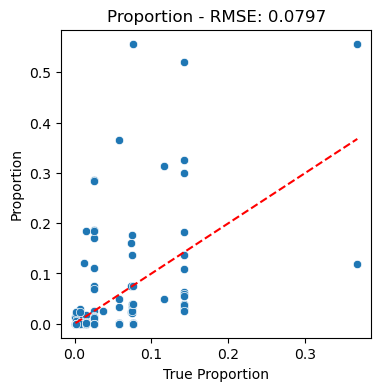

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [377]:
min_val = min(performance_eval_lca_95["True Proportion"].min(), performance_eval_lca_95["True Proportion"].min())
max_val = max(performance_eval_lca_95["True Proportion"].max(), performance_eval_lca_95["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    try:
        plt.figure()
        tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")].reset_index(drop=True)
        sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
        rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
        plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
        plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')
    except:
        pass

/tmp/ipykernel_30982/333957167.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/333957167.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/333957167.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)


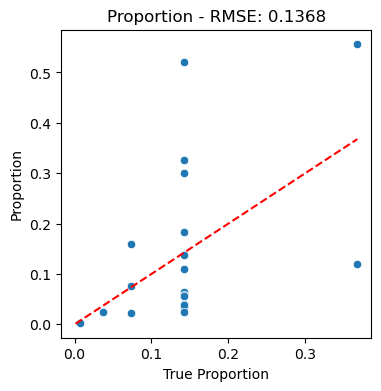

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [376]:
min_val = min(performance_eval_lca_95["True Proportion"].min(), performance_eval_lca_95["True Proportion"].min())
max_val = max(performance_eval_lca_95["True Proportion"].max(), performance_eval_lca_95["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    try:
        plt.figure()
        tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
        sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
        rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
        plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
        plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')
    except:
        pass

/tmp/ipykernel_30982/4111626646.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/4111626646.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/4111626646.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval_lca_95[performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)


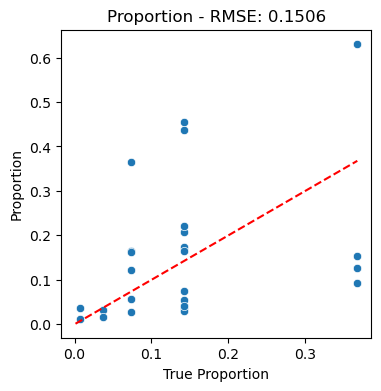

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [375]:
min_val = min(performance_eval_lca_95["True Proportion"].min(), performance_eval_lca_95["True Proportion"].min())
max_val = max(performance_eval_lca_95["True Proportion"].max(), performance_eval_lca_95["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    try:
        plt.figure()
        tmp = performance_eval_lca_95[performance_eval_lca_95["Type"].str.contains("targetref")][performance_eval_lca_95["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
        sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
        rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
        plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
        plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')
    except:
        pass

In [ ]:
min_val = min(performance_eval_lca_95["True Proportion"].min(), performance_eval_lca_95["True Proportion"].min())
max_val = max(performance_eval_lca_95["True Proportion"].max(), performance_eval_lca_95["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    try:
        plt.figure()
        tmp = performance_eval_lca_95[~performance_eval_lca_95["Type"].str.contains("targetref")].reset_index(drop=True)
        sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
        rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
        plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
        plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')
    except:
        pass

In [360]:
performance_eval = pd.DataFrame()
for abundances in glob.glob("../data/*.abundances"):
    mix = abundances.split("/")[2].split("_")[0]
    type = abundances.split("/")[2]
    tmp = mixes.copy()
    tmp["True Proportion"] = tmp.groupby(["Mix", "TaxName"])["True Proportion"].transform('sum')
    tmp = tmp.drop_duplicates(subset= ['Mix', 'TaxName'], keep = "first").reset_index(drop=True)
    assignments = pd.read_csv(abundances)
    assignments["Mix"] = mix
    assignments["Type"] = type
    assignments["Proportion"] = assignments["Assigned_Bases"] / assignments["Assigned_Bases"][assignments["Rank"] == "species"].sum()
    assignments = assignments.merge(tmp[["Mix", "TaxName", "True Proportion"]], how = "left", on = ["Mix", "TaxName"])
    performance_eval = pd.concat([performance_eval, assignments]).reset_index(drop=True)

In [ ]:
["MixA", "MixB", "MixC", "MixD"]

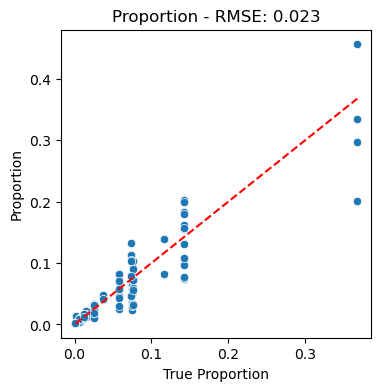

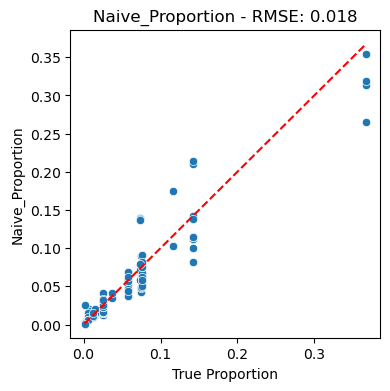

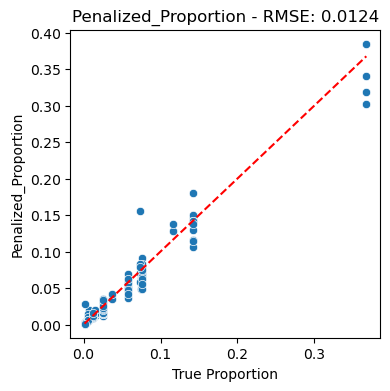

In [365]:
min_val = min(performance_eval["True Proportion"].min(), performance_eval["True Proportion"].min())
max_val = max(performance_eval["True Proportion"].max(), performance_eval["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    plt.figure()
    tmp = performance_eval[~performance_eval["Type"].str.contains("targetref")].reset_index(drop=True)
    sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
    rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
    plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
    plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')

/tmp/ipykernel_30982/727683237.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval[~performance_eval["Type"].str.contains("targetref")][performance_eval["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/727683237.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval[~performance_eval["Type"].str.contains("targetref")][performance_eval["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
/tmp/ipykernel_30982/727683237.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = performance_eval[~performance_eval["Type"].str.contains("targetref")][performance_eval["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)


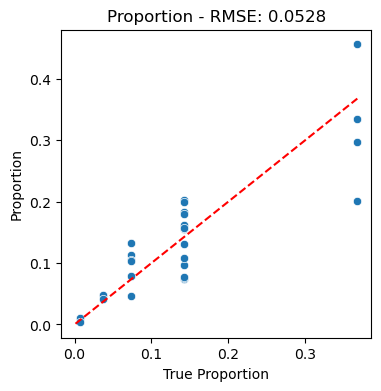

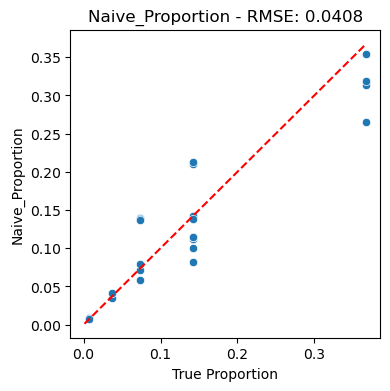

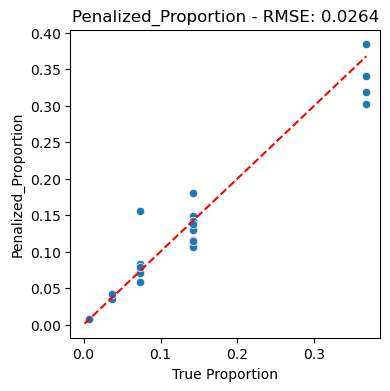

In [364]:
min_val = min(performance_eval["True Proportion"].min(), performance_eval["True Proportion"].min())
max_val = max(performance_eval["True Proportion"].max(), performance_eval["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    plt.figure()
    tmp = performance_eval[~performance_eval["Type"].str.contains("targetref")][performance_eval["Mix"].isin(["MixA", "MixB", "MixC", "MixD"])].reset_index(drop=True)
    sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
    rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
    plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
    plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')

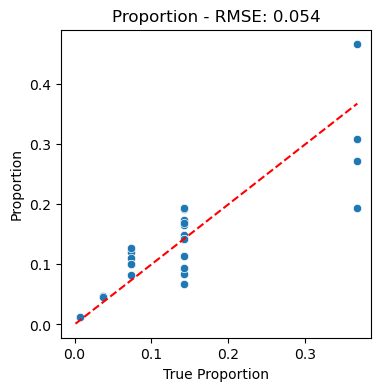

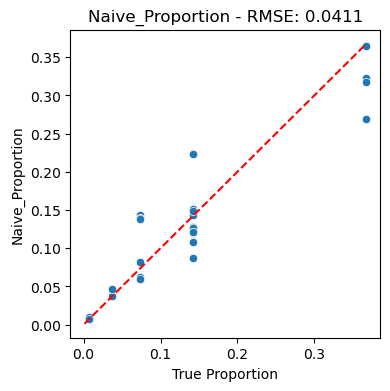

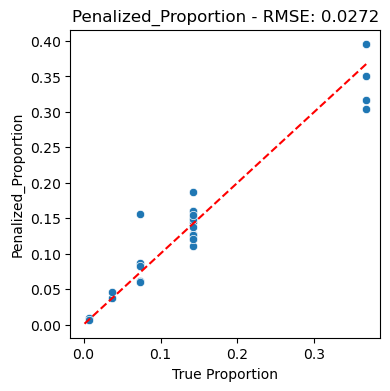

In [362]:
min_val = min(performance_eval["True Proportion"].min(), performance_eval["True Proportion"].min())
max_val = max(performance_eval["True Proportion"].max(), performance_eval["True Proportion"].max())
x_line = np.linspace(min_val, max_val, 100) 
plt.rcParams["figure.figsize"] = (4,4)
for prop in ["Proportion", "Naive_Proportion", "Penalized_Proportion"]:
    plt.figure()
    tmp = performance_eval[performance_eval["Type"].str.contains("targetref")].reset_index(drop=True)
    sns.scatterplot(data = tmp, x = "True Proportion", y = prop)
    rmse = np.sqrt(np.mean((tmp[prop] - tmp["True Proportion"]) ** 2))
    plt.title(prop + " - RMSE: " + str(round(rmse, 4)))
    plt.plot(x_line, x_line, color='red', linestyle='--', label='1:1 Line')

In [35]:
import pandas as pd
import numpy as np

# Example distance matrix with duplicated taxIDs in both index and columns
distance_matrix = pd.DataFrame([
    [0.00, 0.04, 0.07, 0.07, 0.07],
    [0.04, 0.00, 0.08, 0.08, 0.08],
    [0.07, 0.08, 0.00, 0.00, 0.01],
    [0.07, 0.08, 0.00, 0.00, 0.05],
    [0.07, 0.08, 0.01, 0.05, 0.00],
], index=[217026, 8236, 13676, 13676, 338315], columns=[217026, 8236, 13676, 13676, 338315])

# Step 1: Group rows and columns by taxID
# Average all rows with the same taxID
grouped_rows = distance_matrix.groupby(distance_matrix.index).mean()
grouped_full = grouped_rows.T.groupby(distance_matrix.columns, axis=0).mean().T

# Step 2: Ensure symmetry (optional but good practice for distances)
# Average the matrix with its transpose
symmetric_matrix = (grouped_full + grouped_full.T) / 2

# Step 3: Fill diagonal with 0 (optional)
np.fill_diagonal(symmetric_matrix.values, 0)

# Final result
print(symmetric_matrix)


        8236    13676   217026  338315
8236      0.00    0.08    0.04    0.08
13676     0.08    0.00    0.07    0.03
217026    0.04    0.07    0.00    0.07
338315    0.08    0.03    0.07    0.00


/tmp/ipykernel_30982/546818455.py:18: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  grouped_full = grouped_rows.T.groupby(distance_matrix.columns, axis=0).mean().T


In [112]:
import pandas as pd

# Example distance matrix (species names as rows and columns)
distance_matrix = pd.DataFrame({
    217026: {217026: 0, 8236: 0.04, 13676: 0.07, 13676: 0.07, 338315: 0.07},
    8236: {217026: 0.04, 8236: 0, 13676: 0.08, 13676: 0.08, 338315: 0.08},
    13676: {217026: 0.07, 8236: 0.08, 13676: 0, 13676: 0.05, 338315: 0.01},
    13676: {217026: 0.07, 8236: 0.08, 13676: 0.05, 13676: 0, 338315: 0.05},
    338315: {217026: 0.07, 8236: 0.08, 13676: 0.01, 13676: 0.05, 338315: 0},
})

# observed_read_counts uses taxids
read_counts = {
    8224: 300, # Scombridae
    217026: 300, # Auxis rochei
    8236: 300, # Thunnus thynnus
    13675: 150,  # Scomber
    13676: 50,  # S_japonicus
    13677: 50,   # S_scomber
    338315: 50  # S_colias
}

naive_final, mash_final= propagate_counts(
    taxid_list=list(read_counts.keys()),
    nodes_path="../examples/nodes.dmp.gz",
    names_path="../examples/names.dmp.gz",
    observed_read_counts=read_counts,
    mash_penalty=True,
    distance_matrix=distance_matrix
)


In [134]:
tests = pd.read_csv("../examples/MixA_bowtie_global.abundances")
tests["Proportion"] = tests["Assigned_Bases"] / tests["Assigned_Bases"].sum()
mixes = pd.read_csv("../data/mixes_for_ngsLCA_tests.csv")
mixes["TaxName"] = mixes["Constituent"].str.replace("_", " ")
mixes["True Proportion"] = mixes["Proportion"]
tests = tests.merge(mixes[["TaxName", "True Proportion"]][mixes["Mix"] == "MixE"], how = "left", on = "TaxName")

In [123]:
import numpy as np

true = np.array(tests["True Proportion"].tolist())      # your true values, e.g. [2.5, 2.5, 2.5]
predicted = np.array(tests["Proportion"].tolist())  # your predicted values

rmse = np.sqrt(np.mean((predicted - true) ** 2))
print(f"RMSE: {rmse}")


RMSE: 0.006270400844234428


In [125]:
true = np.array(tests["True Proportion"].tolist())      # your true values, e.g. [2.5, 2.5, 2.5]
predicted = np.array(tests["Naive_Proportion"].tolist())  # your predicted values

rmse = np.sqrt(np.mean((predicted - true) ** 2))
print(f"RMSE: {rmse}")


RMSE: 0.004643126912071987


In [124]:
true = np.array(tests["True Proportion"].tolist())      # your true values, e.g. [2.5, 2.5, 2.5]
predicted = np.array(tests["Penalized_Proportion"].tolist())  # your predicted values

rmse = np.sqrt(np.mean((predicted - true) ** 2))
print(f"RMSE: {rmse}")


RMSE: 0.004113186855134322


In [126]:
np.mean(np.abs(np.array(tests["Penalized_Proportion"].tolist())-0.025))

0.003053718043585278

In [127]:
np.mean(np.abs(np.array(tests["Proportion"].tolist())-0.025))

0.005292258743986285

In [128]:
np.mean(np.abs(np.array(tests["Naive_Proportion"].tolist())-0.025))

0.0032189025541945657

In [129]:
from scipy.stats import chisquare
chisquare(f_obs=np.array(tests["Penalized_Proportion"].tolist()), f_exp=np.array(tests["True Proportion"].tolist()))

Power_divergenceResult(statistic=0.02706928976839964, pvalue=1.0)

In [130]:
chisquare(f_obs=np.array(tests["Proportion"].tolist()), f_exp=np.array(tests["True Proportion"].tolist()))

Power_divergenceResult(statistic=0.0629086827958013, pvalue=1.0)

In [131]:
chisquare(f_obs=np.array(tests["Naive_Proportion"].tolist()), f_exp=np.array(tests["True Proportion"].tolist()))

Power_divergenceResult(statistic=0.034493804034571446, pvalue=1.0)

In [12]:
import pandas as pd
from io import StringIO

# Load Mash distances
df = pd.read_csv("alldists.tsv", sep="\t", header=None,
                 names=["species1", "species2", "distance", "shared", "pvalue"])

# Get unique species names
species = sorted(set(df["species1"]).union(set(df["species2"])))
species_clean = [s.replace(".fa.gz", "").replace("./reference_genomes/", "") for s in species]

# Initialize distance matrix
dist_matrix = pd.DataFrame(0.0, index=species_clean, columns=species_clean)

# Fill the matrix with Mash distances
for _, row in df.iterrows():
    s1 = row["species1"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    s2 = row["species2"].replace(".fa.gz", "").replace("./reference_genomes/", "")
    dist_matrix.loc[s1, s2] = row["distance"]
    dist_matrix.loc[s2, s1] = row["distance"]

In [13]:
dist_matrix_subset = dist_matrix.reset_index(drop=False)

In [14]:
perc_correct = []
closest = []
taxa = []
for sp in ["Scomber_japonicus"]:
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

In [20]:
mismap["TotalBases"][mismap["Constituent"] == "Scomber_colias"].sum() / totaltospecies

0.21057996270606047

In [15]:
correctlymapped

4097153

In [73]:
perc_correct = []
closest = []
taxa = []
for sp in set(keys["Constituent"][keys["Mix"] == "MixE"].tolist()):
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

In [134]:
perc_correct = []
closest = []
taxa = []
for sp in ["Clupea_harengus"]:
    mismap = (test[(test["TaxName"] == sp.replace("_", " ")) 
              & (~test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist())))]).copy()
    mismap["sample"] = mismap["ReadName"].str.split(".", expand = True)[0]
    mismap["sample"] = mismap["sample"].str.rsplit("_", expand = True, n = 1)[0]
    mismap = mismap.merge(samplemap[["sample", "Constituent"]], how = "left", on = "sample").reset_index(drop=True)
    wrongtaxa = mismap["Constituent"].unique()
    correctlymapped = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))]))
    totaltospecies = (sum(test["TotalBases"][test["TaxName"] == sp.replace("_", " ")]))
    closestwrong = dist_matrix_subset[sp][dist_matrix_subset[sp] != 0][dist_matrix_subset["index"].isin(wrongtaxa)].sort_values().reset_index(drop=True)[0]
    perc_correct = perc_correct + [correctlymapped / totaltospecies]
    closest = closest + [closestwrong]
    taxa = taxa + [sp]
perc_correct = np.array(perc_correct)
closest = np.array(closest)

/tmp/ipykernel_124/3076865690.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test["R2_AvgQual"][test["TaxName"] == sp.replace("_", " ")]


<Axes: xlabel='R2_AvgQual', ylabel='Density'>

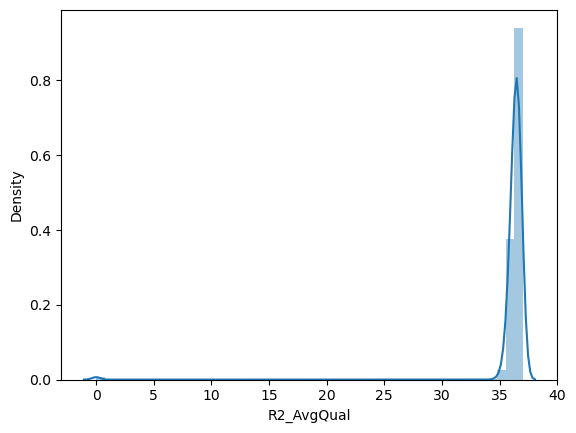

In [135]:
sns.distplot(test["R2_AvgQual"][test["TaxName"] == sp.replace("_", " ")]
                [test["ReadName"].str.contains("|".join(keys["Run"][keys["Mix"] == "MixE"][keys["Constituent"] == sp].tolist()))])

In [137]:
mismap

,ReadName,TaxID,TaxName,Rank,TotalBases,BestIdentity,ReadPairConcordance,R1_Length,R1_Matches,R1_Insertions,...,R1_AvgQual,R2_Length,R2_Matches,R2_Insertions,R2_Deletions,R2_Softclips,R2_Hardclips,R2_AvgQual,sample,Constituent
0,A_sapidissima_E00526:585:HJLFCCCX2:6:1114:1631...,7950,Clupea harengus,species,125,0.2080,unpaired,125,0,0,...,39.32,0,0,0,0,0,0,0.0,A_sapidissima,Alosa_sapidissima
1,B_patronus_SRR21844101.123497.2,7950,Clupea harengus,species,148,0.5203,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
2,B_patronus_SRR21844101.182355.2,7950,Clupea harengus,species,39,1.0000,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
3,B_patronus_SRR21844101.190457.1,7950,Clupea harengus,species,149,0.6510,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
4,B_patronus_SRR21844101.351274.1,7950,Clupea harengus,species,149,0.5973,unpaired,0,0,0,...,0.00,0,0,0,0,0,0,0.0,B_patronus,Brevoortia_patronus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,Z_faber_E00526:585:HJLFCCCX2:6:1221:15727:3313,7950,Clupea harengus,species,148,0.2365,unpaired,148,0,0,...,40.15,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
542,Z_faber_E00526:585:HJLFCCCX2:6:2102:12976:11171,7950,Clupea harengus,species,125,0.2240,unpaired,125,0,0,...,40.36,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
543,Z_faber_E00526:585:HJLFCCCX2:6:2108:12510:20243,7950,Clupea harengus,species,123,0.2764,unpaired,123,0,0,...,40.03,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber
544,Z_faber_E00526:585:HJLFCCCX2:6:2121:6431:32812,7950,Clupea harengus,species,149,0.3356,unpaired,149,0,0,...,40.14,0,0,0,0,0,0,0.0,Z_faber,Zeus_faber


/tmp/ipykernel_124/1944317509.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mismap["R1_AvgQual"])


<Axes: xlabel='R1_AvgQual', ylabel='Density'>

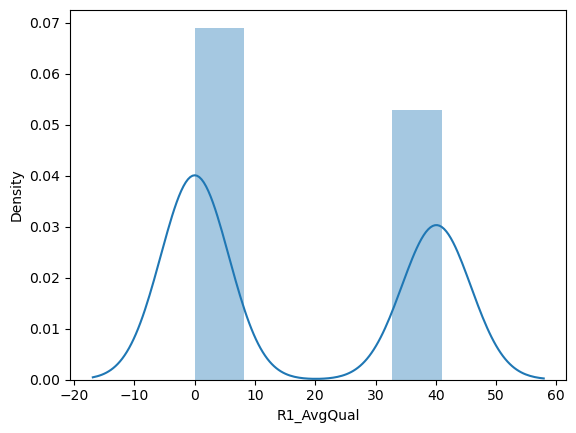

In [136]:
sns.distplot(mismap["R1_AvgQual"])

In [99]:
tests = pd.DataFrame(data = [closest, perc_correct, taxa]).T

Text(0.5, 0, 'Mash Distance of Most Closely Related Mismap')

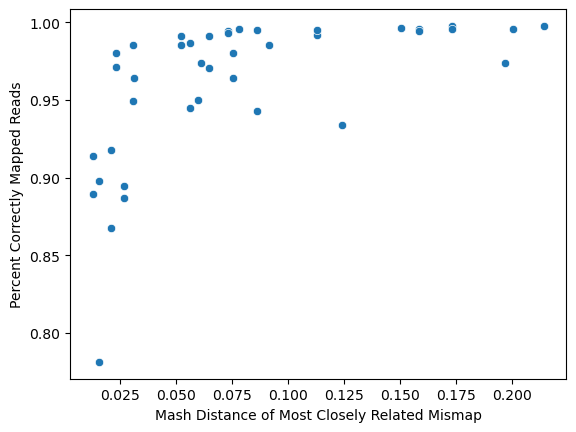

In [93]:
sns.scatterplot(x = closest, y = perc_correct)
plt.ylabel("Percent Correctly Mapped Reads")
plt.xlabel("Mash Distance of Most Closely Related Mismap")


✅ Best model: Weibull CDF
R² = 0.57687
Parameters: [0.99097066 0.00240406 0.43930711]


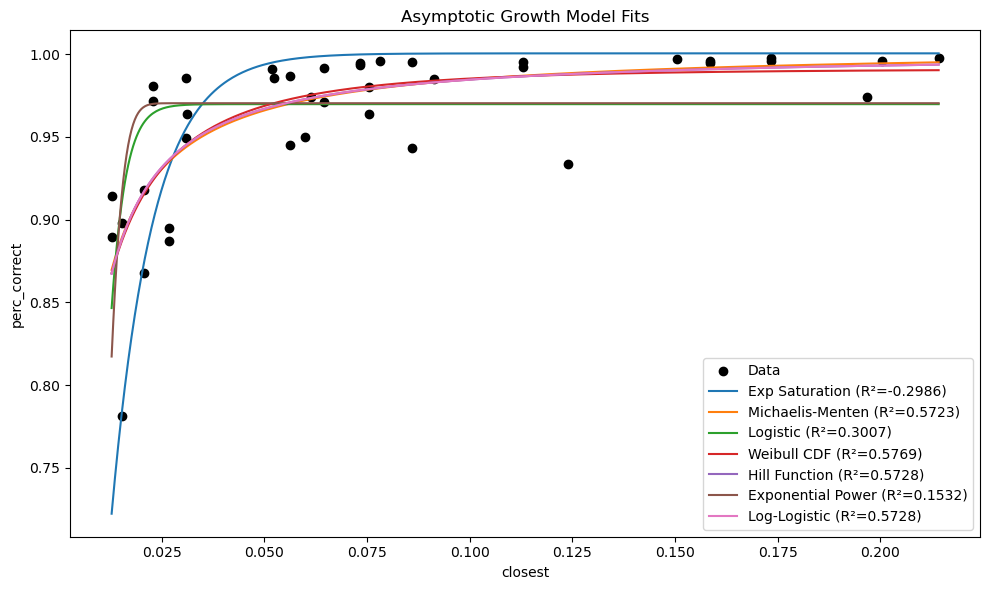

In [92]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# 1. Define all asymptotic models
# Models
def exp_saturation(x, a, b):
    return a * (1 - np.exp(-b * x))

def michaelis_menten(x, a, b):
    return (a * x) / (b + x)

def logistic(x, L, k, x0):
    base = 1 / (1 + np.exp(-k * (x - x0)))
    offset = 1 / (1 + np.exp(k * x0))  # value at x=0
    return L * (base - offset)

def weibull_cdf(x, a, b, c):
    return a * (1 - np.exp(- (x / b) ** c))

def hill_function(x, a, k, n):
    return a * (x**n) / (k**n + x**n)

def exp_power(x, a, b, c):
    return a * (1 - np.exp(-(b * x)**c))

def log_logistic(x, a, b, c):
    return a / (1 + (x / b) ** -c)


# Reasonable initial guesses and bounds
max_y = np.array(perc_correct).max()
x_median = np.median(np.array(closest))
models = {
    'Exp Saturation': (exp_saturation, [max_y, 10], (0, [1.1 * max_y, 100])),
    'Michaelis-Menten': (michaelis_menten, [max_y, x_median], (0, [1.1 * max_y, 1.0])),
    'Logistic': (logistic, [max_y, 100, x_median], (0, [1.1 * max_y, 1000, 1.0])),
    'Weibull CDF': (weibull_cdf, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10])),
    'Hill Function': (hill_function, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10])),
    'Exponential Power': (exp_power, [max_y, 10, 1.0], (0, [1.1 * max_y, 100, 10])),
    'Log-Logistic': (log_logistic, [max_y, x_median, 2.0], (0, [1.1 * max_y, 1.0, 10]))
}


# Fit models
fit_results = {}

for name, (func, p0, bounds) in models.items():
    try:
        popt, _ = curve_fit(func, closest, perc_correct, p0=p0, bounds=bounds, maxfev=10000)
        y_pred = func(closest, *popt)
        r2 = r2_score(perc_correct, y_pred)
        fit_results[name] = {'params': popt, 'r2': r2, 'func': func}
    except Exception as e:
        print(f"❌ {name} failed to fit: {e}")

# Best model
best_name, best_info = max(fit_results.items(), key=lambda kv: kv[1]['r2'])
print(f"\n✅ Best model: {best_name}")
print(f"R² = {best_info['r2']:.5f}")
print("Parameters:", best_info['params'])

# Plot
x_fit = np.linspace(min(closest), max(closest), 500)
plt.figure(figsize=(10, 6))
plt.scatter(closest, perc_correct, label='Data', color='black')

for name, info in fit_results.items():
    y_fit = info['func'](x_fit, *info['params'])
    plt.plot(x_fit, y_fit, label=f"{name} (R²={info['r2']:.4f})")

plt.xlabel("closest")
plt.ylabel("perc_correct")
plt.legend()
plt.title("Asymptotic Growth Model Fits")
plt.tight_layout()
plt.show()